In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import glob 
from collections import deque
font = cv2.FONT_HERSHEY_SIMPLEX

%matplotlib inline

# Fn for collecting matrix of objp's and image points and calibrating
def get_img_pts_calib(calib_image_set):
    objpoints = []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    imgpoints = []
    nx, ny = 9, 6
    for fname in calib_image_set:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True: 
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    return objpoints, imgpoints

#	Now that we have the matrices (imgpoints and objpoints) we can calibrat & undistort the images
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[:2]), None, None)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image       

#Method for plotting before and after
def plotting(img1, img2, title1 ='title1', title2 = 'title2', gray = 'no'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    if gray == 'no':
        ax2.imshow(img2)
    else:
        ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#Getting images to test on
chsbrd_images = glob.glob('CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')
test_images = glob.glob('CarND-Advanced-Lane-Lines/test_images/test*.jpg')

objpoints, imgpoints = get_img_pts_calib(chsbrd_images)

Confirm that the undistortion is applied correctly, both to the chessboard images, and to the tst images from the video

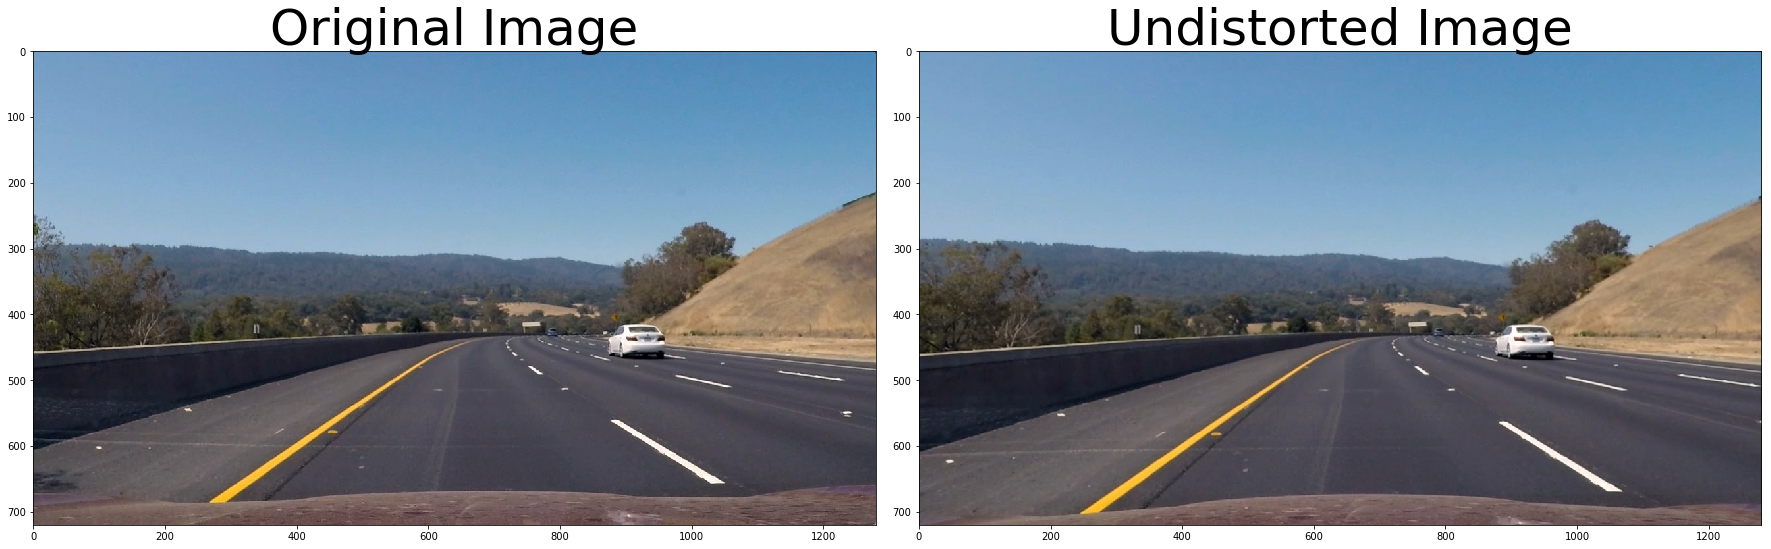

In [2]:
#Print a test image before and after undistortion
test_image = mpimg.imread(test_images[2])
#Reading in a single image:...
#      test_image = mpimg.imread('CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg')
undistorted = cal_undistort(test_image, objpoints, imgpoints)
plotting(test_image, undistorted, 'Original Image', 'Undistorted Image')

#### Grad Thresh

In [3]:
# Now define the methods for the 3 gradient threshold techniques
def abs_sobel_thresh(img, orient='x', s_kernel = 3, thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary 

def mag_thresh(img, s_kernel= 3, thresh=(0, 255)): 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel)
    gradmag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag < thresh[1])] = 1
    return binary_output 

def dir_thresh(img, s_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = s_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = s_kernel))
    grad_dir = np.arctan2(abs_sobelx, abs_sobely)
    bin_mask = np.zeros_like(grad_dir)
    bin_mask[(grad_dir > thresh[0]) & (grad_dir < thresh[1])] = 1
    return bin_mask

# Now define a method for combining the three methods: 
#THIS SHOULD CHANGE AS I TUNE PARAMETERS!
def combine_grad_thresh(img):
    #Run above methods with selected parameters for thresh & ksize
    gradx = abs_sobel_thresh(img, orient='x', s_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', s_kernel=3, thresh=(5, 100))
    mag_binary = mag_thresh(img, s_kernel=5, thresh=(30, 100))
    dir_binary = dir_thresh(img, s_kernel=11, thresh=(0.7, 1.3))
    #make a combination of them...
    combined_sobel = np.zeros_like(dir_binary)
    combined_sobel[(gradx == 1) & (grady == 1) | ((mag_binary == 1) & ( dir_binary ==1)) ] = 1
    return combined_sobel

#### Color Thresholding

In [4]:
# Color thresholding, taking the saturation channel from the HLS color space
def hls_saturation(img, thresh=(90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_s = np.zeros_like(s)
    binary_s[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return binary_s

#### Combined Color and Grad Thresh

In [5]:
# Now, COMBINE color and grad!!!!
def combined(img):
    #grd = combine_grad_thresh(img)
    grd = abs_sobel_thresh(img, orient='x', s_kernel = 3, thresh=(5,100))
    sat = hls_saturation(img)
    comb_bin = np.zeros_like(grd)
    comb_bin[(grd == 1) & (sat == 1)] = 1
    return comb_bin

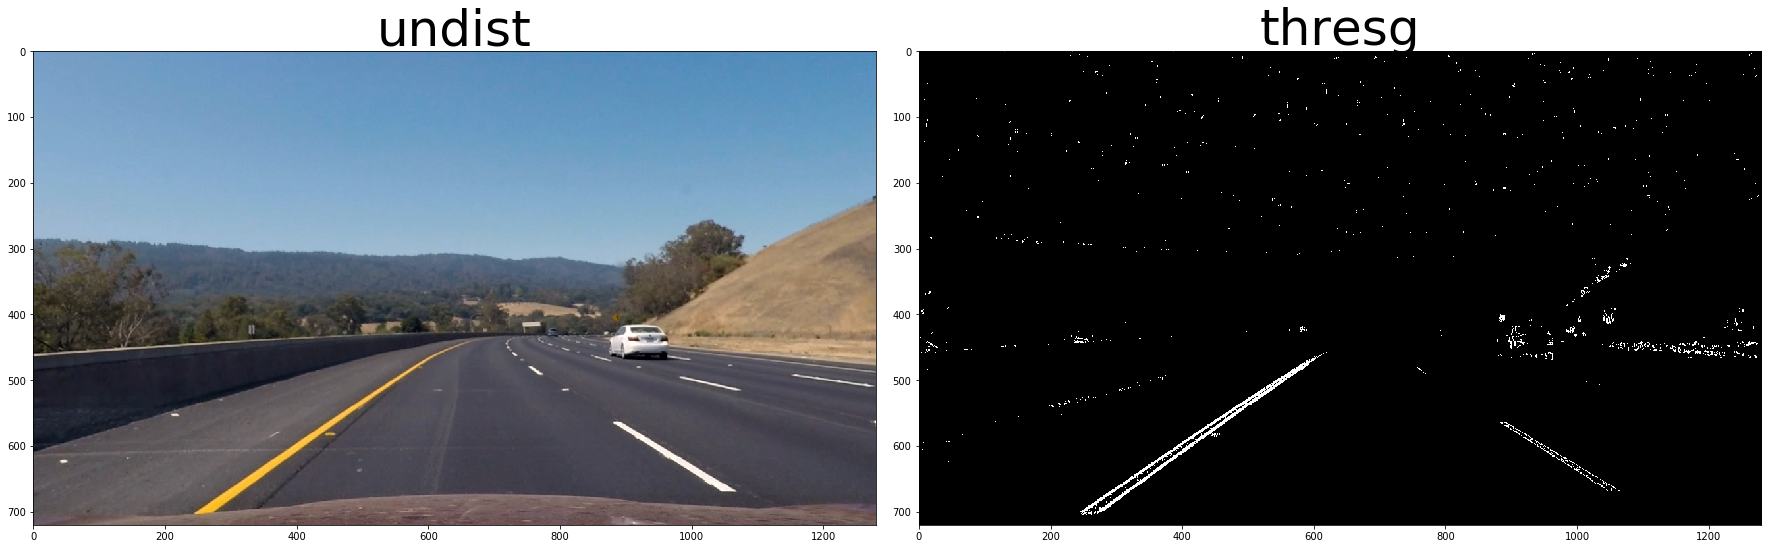

In [6]:
lines_detected = combined(undistorted)
plotting(undistorted, lines_detected, 'undist', 'thresg', 'yes')

In [7]:
#### Prespective Transform

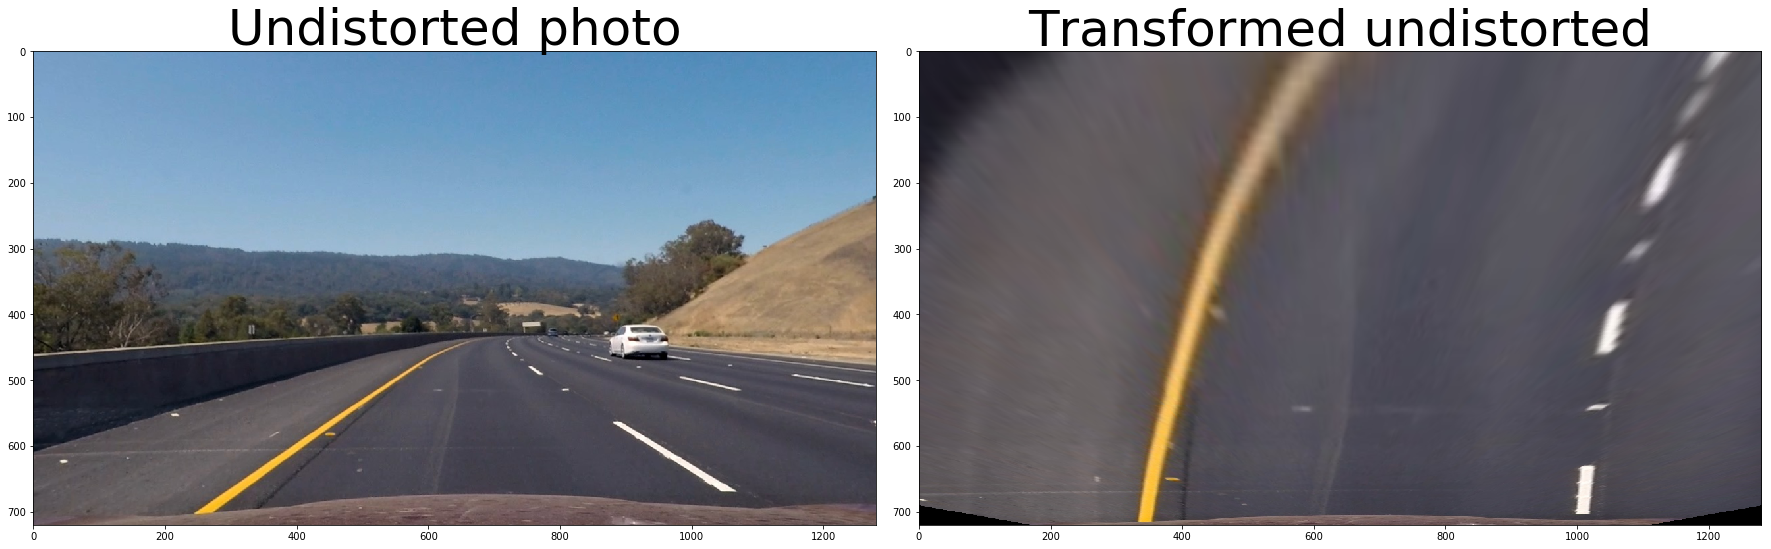

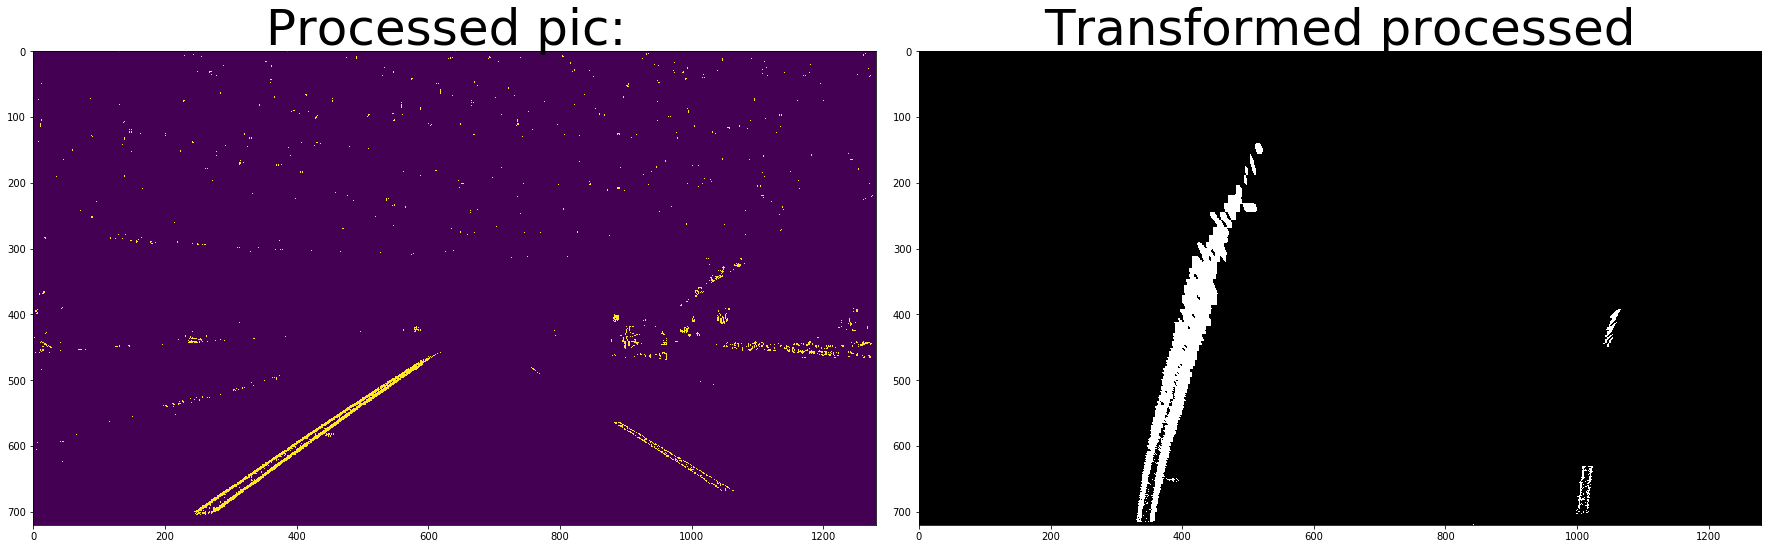

In [8]:
def transform(img):
    (h, w) = (img.shape[0], img.shape[1])
    src = np.float32([[w // 2 - 76, h * .625], [w // 2 + 76, h * .625], [-100, h], [w + 100, h]])
    dest = np.float32([[100, 0], [w - 100, 0], [100, h], [w - 100, h]])
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    transformed = cv2.warpPerspective(img, M, (w, h))
    return transformed, M, Minv

#First, transform perspective of the actual undistorted pic
top_down, M, Minv = transform(undistorted)
plotting(undistorted, top_down, 'Undistorted photo', 'Transformed undistorted') 

# Then of the one with all processing
top_down = transform(lines_detected)[0]
plotting(lines_detected, top_down, 'Processed pic: ', 'Transformed processed', 'yes') 

### Make a histogram to locate lines: 

**FUNCTION FOR FINDING LINES FROM SCRATCH**

In [ ]:
def find_lines(bin_warped, orig_img, Minv):
    "This function finds the lines from scratch, using sliding windows"
    
    unprocessed = False
    
    histogram = np.sum(bin_warped[int(bin_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print("showing the histogram: ")
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((bin_warped, bin_warped, bin_warped))*255
    # Choose the number of sliding windows - will go for 9
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_warped.shape[0] - (window+1)*window_height
        #print("WINLOW:",win_y_low )
        win_y_high = bin_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)\
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low)\
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found more pixels than minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #For ease of transfer
    pix_pos_zeros = [leftx, lefty, rightx, righty, nonzerox, nonzeroy, left_lane_inds,\
                     right_lane_inds, left_fitx, right_fitx, ploty]

    return left_fit, right_fit, pix_pos_zeros, out_img

In [ ]:
def plotting_curvature_position(bin_warped, orig_img, Minv, left_fit, right_fit, pix_pos_zeros, out_img):
    #Plotting
    left_lane_inds = []
    right_lane_inds = []
    
    #unpacking from findlines methods
    leftx, lefty, rightx, righty, nonzerox, nonzeroy, left_lane_inds,\
                     right_lane_inds, left_fitx, right_fitx, ploty = pix_pos_zeros
    
    y_eval = np.max(ploty)
    
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #Lane curvature
    ym_per_pix = 3.7 / 82  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 790  # meters per pixel in x dimension
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    
    #Vehicle position
    left_lane_bottom = left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + left_fit_cr[1] * (y_eval * ym_per_pix) + \
                       left_fit_cr[2]
    #calculate the x position for y at the height of the image for right lane                   
    right_lane_bottom = right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + right_fit_cr[1] * (y_eval * ym_per_pix) + \
                        right_fit_cr[2]
    #calculate the mid point of identified lane
    lane_midpoint = float(right_lane_bottom - left_lane_bottom) / 2
    lane_deviation = 0.0;
    #calculate the image center in meters from left edge of the image to right edge of image
    image_mid_point_in_meter = lane_midpoint * xm_per_pix;
    # positive value indicates car is right of lane center lane, else left. Multiply by 100 to convert to centimeter
    lane_deviation = (image_mid_point_in_meter - lane_midpoint)
    lane_deviation = 0.2*lane_deviation
    
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    #Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    left_radius = 'Left-lane radius: %.2f m' % left_curverad
    right_radius = 'Right-lane radius: %.2f m' % right_curverad
    if lane_deviation > 0:
        deviation = "Lane deviation: %.2f m to the right" % lane_deviation
    else:
        deviation = -lane_deviation
        deviation = "Lane deviation: %.2f m to the left" % lane_deviation
        
    cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
    cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
    cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)
    return out_img, result, left_fitx, right_fitx, ploty 

In [ ]:
def already_found(left_fit, right_fit, bin_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "bin_warped")
    # It's now much easier to find line pixels!
    
    unprocessed = False
    
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    if left_lane_inds or right_lane_inds == None:
        left_lane_inds = global_left_lane_inds
        right_lane_inds = globalright_lane_inds
        
        unprocessed = True
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    pix_pos_zeros = [leftx, lefty, rightx, righty, nonzerox, nonzeroy]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((bin_warped, bin_warped, bin_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    '''plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)'''
    return left_fit, right_fit, pix_pos_zeros, out_img, unprocessed

In [ ]:
def visualizing_resultA(out_img, result, left_fitx, right_fitx, ploty):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title("Finding Lines", fontsize=50)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax2.imshow(result)
    ax2.set_title("Drawing on Orignal:", fontsize=30)

In [ ]:
def visualizing_result2(result):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax2.imshow(result)
    ax2.set_title("Drawing on Orignal:", fontsize=30)

Trying this out for the same result

In [ ]:
left_fit, right_fit, pix_pos_zeros, out_img = find_lines(top_down, undistorted, Minv)
out_img, result, left_fitx, right_fitx, ploty   = plotting_curvature_position(top_down, \
    undistorted, Minv, left_fit, right_fit, pix_pos_zeros, out_img)
visualizing_resultA(out_img, result, left_fitx, right_fitx, ploty)

### Trying with already found lines: 

In [ ]:
left_fit, right_fit, pix_pos_zeros, out_img = already_found(left_fit, right_fit, top_down)
out_img, result, left_fitx, right_fitx, ploty   = plotting_curvature_position(top_down, \
    undistorted, Minv, left_fit, right_fit, pix_pos_zeros, out_img)
visualizing_resultA(out_img, result, left_fitx, right_fitx, ploty)

In [ ]:
def image_pipeline(image):
    lines_detected = combined(image)
    top_down, M, Minv = transform(lines_detected)
    init_windows = False
    left_fit, right_fit, pix_pos_zeros, out_img, unprocessed = find_lines(top_down, orig_img, Minv)
    init_windows = False
    if left_fit == None pr right_fit == None: 
        
    global_left_lane_inds = None
    globalright_lane_inds = None
    
          
    
    

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def find_vid_frame(image):
    found_lines = combined(image)
    top_down, M, Minv = transform(found_lines)
    left_fit, right_fit, pix_pos_zeros, out_img = find_lines(top_down, image, Minv)
    out_img, result, left_fitx, right_fitx, ploty   = plotting_curvature_position(top_down, image, Minv, left_fit, right_fit, pix_pos_zeros, out_img)
    return result
      

In [ ]:
white_output = 'white2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(find_vid_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

# Starting again

Finding Window - takes in trsnformedPerspe(bin_warped, orig img) 
and outputs left_fit, right_fit

In [9]:
def find_lines_scratch(lf, rf, bin_warped, orig_img):
    '''global left_fit
    global right_fit
    This function finds the lines from scratch, using sliding windows'''
    histogram = np.sum(bin_warped[int(bin_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((bin_warped, bin_warped, bin_warped))*255
    # Choose the number of sliding windows - will go for 9
    nwindows = 9
    # Set height of windows
    window_height = np.int(bin_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = bin_warped.shape[0] - (window+1)*window_height
        #print("WINLOW:",win_y_low )
        win_y_high = bin_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low)\
                          & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low)\
                           & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found more pixels than minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    if leftx.size == 0 or lefty.size == 0 or rightx.size == 0 or righty.size == 0:
        return lf, rf
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

def process_lines(leftx_coef, rightx_coef, dist_between, left_fit, right_fit, bin_warped, undistorted, deviat, leftrad, rightrad):

    '''   This is the code for processing the pixels and getting polys for lane lines
    '''
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "bin_warped")
    # It's now much easier to find line pixels!
    #     unprocessed = False
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
    warp_zero = np.zeros_like(bin_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #If coeffs (therefore co-ordinates as well) were not found, even from scratch, then 
    # just use lines stored in the deque and DONT APPEND ANYTHING
    if (len(left_fit) == 0) or (len(right_fit) == 0):
        left_fitx, right_fitx = leftx_coef[-1], rightx_coef[-1]
        deviation = deviat[-1]
        left_radius = leftrad[-1]
        right_radius = rightrad[-1]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        #Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

        cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
        cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
        cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)
        '''ignoring radius for a second
        left_radius = 'Left-lane radius: %.2f m' % left_curverad
        right_radius = 'Right-lane radius: %.2f m' % right_curverad
        if lane_deviation > 0:
            deviation = "Lane deviation: %.2f m to the right" % lane_deviation
        else:
            deviation = -lane_deviation
            deviation = "Lane deviation: %.2f m to the left" % lane_deviation
            
        cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
        cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
        cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)'''
        #GLOBAL_LLI = []
        #GLOBAL_RLI = []
        #return rl_dif, result, left_fitx, right_fitx, ploty, out_img, left_lane_inds, right_lane_inds, left_fit, right_fit
        appendVals = 0
        return 0,       result, []        , [],[],[],[],[],appendVals,[],[],[]

    else:
        nonzero = bin_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 60
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        #print("what are lll & rll?",'/n', left_lane_inds,'/n',right_lane_inds)
        
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] #first time round
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        #Getting average distance between points on left and right lane
        rl_dif = sum(right_fitx-left_fitx)/len(right_fitx-left_fitx)
        if rl_dif > 1.2*dist_between or rl_dif < 0.8*dist_between:
            left_fitx = leftx_coef[-1] 
            right_fitx = rightx_coef[-1]
            deviation = deviat[-1]
            left_radius = leftrad[-1]
            right_radius = rightrad[-1]
            print("dev",deviation )
            print("lr",left_radius)
            print("rr",right_radius)
                    # Recast the x and y points into usable format for cv2.fillPoly()
            pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
            pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
            pts = np.hstack((pts_left, pts_right))

            # Draw the lane onto the warped blank image
            cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

            #Warp the blank back to original image space using inverse perspective matrix (Minv)
            newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
            # Combine the result with the original image
            result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
            cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
            cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
            cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)
            '''ignoring radius for a second
            left_radius = 'Left-lane radius: %.2f m' % left_curverad
            right_radius = 'Right-lane radius: %.2f m' % right_curverad
            if lane_deviation > 0:
                deviation = "Lane deviation: %.2f m to the right" % lane_deviation
            else:
                deviation = -lane_deviation
                deviation = "Lane deviation: %.2f m to the left" % lane_deviation
                
            cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
            cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
            cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)'''
            #GLOBAL_LLI = []
            #GLOBAL_RLI = []
            #return rl_dif, result, left_fitx, right_fitx, ploty, out_img, left_lane_inds, right_lane_inds, left_fit, right_fit
            appendVals = 0
            print("did we get here?")
            return 0,       result, []        , [],[],[],[],[],appendVals,[],[],[]

        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        #Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

                #Lane curvature
        #leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty = pix_pos_zeros
        y_eval = np.max(ploty)
        ym_per_pix = 3.7 / 82  # meters per pixel in y dimension
        xm_per_pix = 3.7 / 790  # meters per pixel in x dimension
        left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
            2 * right_fit_cr[0])
        #Vehicle position
        left_lane_bottom = left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + left_fit_cr[1] * (y_eval * ym_per_pix) + \
                           left_fit_cr[2]
        #calculate the x position for y at the height of the image for right lane                   
        right_lane_bottom = right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + right_fit_cr[1] * (y_eval * ym_per_pix) + \
                            right_fit_cr[2]
        #calculate the mid point of identified lane
        lane_midpoint = float(right_lane_bottom - left_lane_bottom) / 2
        lane_deviation = 0.0;
        #calculate the image center in meters from left edge of the image to right edge of image
        image_mid_point_in_meter = lane_midpoint * xm_per_pix;
        # positive value indicates car is right of lane center lane, else left. Multiply by 100 to convert to centimeter
        lane_deviation = (image_mid_point_in_meter - lane_midpoint)
        lane_deviation = 0.2*lane_deviation
        
        left_radius = 'Left-lane radius: %.2f m' % left_curverad
        right_radius = 'Right-lane radius: %.2f m' % right_curverad
        if lane_deviation > 0:
            deviation = "Lane deviation: %.2f m to the right" % lane_deviation
        else:
            deviation = -lane_deviation
            deviation = "Lane deviation: %.2f m to the left" % lane_deviation
            
        cv2.putText(result, left_radius,(20,50), font, 1,(255,0,127),2)
        cv2.putText(result, right_radius,(20,100), font, 1,(255,0,127),2)
        cv2.putText(result, deviation,(20,150), font, 1,(255,0,127),2)

        #return rl_dif, result, left_fitx, right_fitx, ploty, out_img, left_lane_inds, right_lane_inds, left_fit, right_fit
        appendVals = 1
        return rl_dif, result, left_fitx, right_fitx,[],[],left_fit, right_fit,appendVals, deviation, left_radius, right_radius 






def visualizing_result(out_img, result, left_fitx, right_fitx, ploty):
    ''' This function is used for debugging, or for just viewing the processed imagery
    '''
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title("Finding Lines", fontsize=50)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax2.imshow(result)
    ax2.set_title("Drawing on Orignal:", fontsize=30)



In [10]:
#GLOBAL VARS
n = 11
left_fit = []
right_fit = []
#deqFrameCounter = deque(maxlen = n)
deqFrameCounter = []
AppendFrames = 1
#previous_coords_l = deque(maxlen= n)
#previous_coords_r = deque(maxlen= n)
leftx_coeffs = deque(maxlen = n)
rightx_coeffs = deque(maxlen = n)
LR_dif = deque(maxlen = n)
deviationDeq = deque(maxlen = n)
left_radiusDeq = deque(maxlen = n)
right_radiusDeq = deque(maxlen = n)
def pipeline(input_image):
    undistorted = cal_undistort(input_image, objpoints, imgpoints)
    found_lines = combined(undistorted)
    top_down, M, Minv = transform(found_lines)
    global left_fit
    global right_fit
    global deqFrameCounter
    global AppendFrames
    global previous_coords_l
    global previous_coords_r
    global leftx_coeffs
    global rightx_coeffs
    global LR_dif
    global deviationDeq
    global left_radiusDeq
    global right_radiusDeq
    
    # In an attempt to prevent indexerrors (deque out of range)
    if len(leftx_coeffs) == 0 or len(rightx_coeffs) == 0:
        leftx_coeffs.append([563.16115018,  562.33019461,  561.50055097,  560.67221927,  559.8451995,
  559.01949167,  558.19509578,  557.37201182,  556.5502398 ,  555.72977971,
  554.91063155,  554.09279534,  553.27627105,  552.46105871,  551.64715829,
  550.83456982,  550.02329327,  549.21332867,  548.404676,    547.59733526])
        rightx_coeffs.append([563.16115018,  562.33019461,  561.50055097,  560.67221927,  559.8451995,
  559.01949167,  558.19509578,  557.37201182,  556.5502398 ,  555.72977971,
  554.91063155,  554.09279534,  553.27627105,  552.46105871,  551.64715829,
  550.83456982,  550.02329327,  549.21332867,  548.404676,    547.59733526])
    
    if len(LR_dif) < 1:
        LR_dif.append(650)
    #print(LR_dif[0])
    LR_difAvg = LR_dif[-1]
    #LR_difAvg = (sum(LR_dif)/(len(LR_dif)-1))
    #print("lr dif avg",LR_difAvg)
    # item_in_deque (have you been adding deque frames for last 2 frames, or last 9, etc
    dq = len(deqFrameCounter)
    #print("dqlen", dq)
    
    if (len(left_fit) == 0) or (len(right_fit) == 0):
        left_fit, right_fit = find_lines_scratch(left_fit, right_fit, top_down, undistorted)

    LR_dif4Frame, result, left_fitx, right_fitx, ploty, out_img, left_fit, right_fit, AppendVals,\
    dev, lr, rr  = process_lines(leftx_coeffs, rightx_coeffs,LR_difAvg, left_fit, right_fit, \
        top_down, undistorted, deviationDeq ,left_radiusDeq ,right_radiusDeq)
    #print("Must append leftx, etc?(0 = NO, 1 = YES)", AppendVals)
    if AppendVals ==  1:
        leftx_coeffs.append(left_fitx)
        rightx_coeffs.append(right_fitx)
        LR_dif.append(LR_dif4Frame)
        deqFrameCounter=[]
        deviationDeq.append(dev)
        left_radiusDeq.append(lr)
        right_radiusDeq.append(rr)   
    else:
        deqFrameCounter.append(1)
        #while dq < 11:
    
    #print("length of deques (leftx): ",len(leftx_coeffs))
    #print("length of deques (rightx): ",len(rightx_coeffs))
    #print("length of deques (deviation): ", len(deviationDeq))
    return result



#pipeline(undistorted)

In [11]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
white_output = 'testing1MayFinetuning.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(22,28)
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  1
[MoviePy] >>>> Building video testing1MayFinetuning.mp4
[MoviePy] Writing video testing1MayFinetuning.mp4


  0%|          | 0/151 [00:00<?, ?it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  2


  1%|          | 1/151 [00:00<00:16,  9.25it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  3


  1%|▏         | 2/151 [00:00<00:16,  8.93it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  4


  2%|▏         | 3/151 [00:00<00:16,  8.95it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  5


  3%|▎         | 4/151 [00:00<00:16,  8.98it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  6


  3%|▎         | 5/151 [00:00<00:16,  8.97it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  7


  4%|▍         | 6/151 [00:00<00:16,  9.03it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  5%|▍         | 7/151 [00:00<00:16,  8.95it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  5%|▌         | 8/151 [00:00<00:16,  8.91it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  6%|▌         | 9/151 [00:01<00:16,  8.83it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  7%|▋         | 10/151 [00:01<00:16,  8.76it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  7%|▋         | 11/151 [00:01<00:16,  8.66it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  8%|▊         | 12/151 [00:01<00:16,  8.56it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  9%|▊         | 13/151 [00:01<00:15,  8.77it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


  9%|▉         | 14/151 [00:01<00:15,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 10%|▉         | 15/151 [00:01<00:15,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 11%|█         | 16/151 [00:01<00:15,  8.66it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 11%|█▏        | 17/151 [00:01<00:15,  8.70it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 12%|█▏        | 18/151 [00:02<00:15,  8.78it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 13%|█▎        | 19/151 [00:02<00:14,  8.88it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 13%|█▎        | 20/151 [00:02<00:14,  8.97it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 15%|█▍        | 22/151 [00:02<00:13,  9.27it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 15%|█▌        | 23/151 [00:02<00:13,  9.44it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 16%|█▌        | 24/151 [00:02<00:13,  9.60it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 17%|█▋        | 26/151 [00:02<00:12,  9.73it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 18%|█▊        | 27/151 [00:02<00:12,  9.72it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 19%|█▊        | 28/151 [00:03<00:12,  9.70it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 20%|█▉        | 30/151 [00:03<00:12,  9.70it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 21%|██        | 32/151 [00:03<00:12,  9.86it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 23%|██▎       | 34/151 [00:03<00:11,  9.92it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 24%|██▍       | 36/151 [00:03<00:11, 10.07it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 25%|██▌       | 38/151 [00:04<00:11, 10.01it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8
dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 26%|██▋       | 40/151 [00:04<00:12,  9.17it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 27%|██▋       | 41/151 [00:04<00:12,  8.89it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 28%|██▊       | 42/151 [00:04<00:12,  8.72it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 28%|██▊       | 43/151 [00:04<00:12,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 29%|██▉       | 44/151 [00:04<00:12,  8.52it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 30%|██▉       | 45/151 [00:04<00:12,  8.56it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 30%|███       | 46/151 [00:05<00:11,  8.79it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 31%|███       | 47/151 [00:05<00:11,  9.00it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 32%|███▏      | 48/151 [00:05<00:11,  9.07it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 32%|███▏      | 49/151 [00:05<00:11,  9.18it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 33%|███▎      | 50/151 [00:05<00:11,  9.11it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 34%|███▍      | 51/151 [00:05<00:10,  9.19it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 34%|███▍      | 52/151 [00:05<00:10,  9.07it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 35%|███▌      | 53/151 [00:05<00:10,  8.92it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 36%|███▌      | 54/151 [00:05<00:11,  8.72it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 36%|███▋      | 55/151 [00:06<00:11,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 37%|███▋      | 56/151 [00:06<00:11,  8.63it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 38%|███▊      | 57/151 [00:06<00:10,  8.63it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 38%|███▊      | 58/151 [00:06<00:10,  8.58it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 39%|███▉      | 59/151 [00:06<00:10,  8.58it/s]

dqlen 0
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 5968.16 m
rr Right-lane radius: 177.06 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 40%|███▉      | 60/151 [00:06<00:11,  8.25it/s]

dqlen 1
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 5968.16 m
rr Right-lane radius: 177.06 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 40%|████      | 61/151 [00:06<00:11,  7.69it/s]

dqlen 2
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 5968.16 m
rr Right-lane radius: 177.06 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 41%|████      | 62/151 [00:06<00:12,  7.37it/s]

dqlen 3
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 42%|████▏     | 63/151 [00:07<00:12,  7.33it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 42%|████▏     | 64/151 [00:07<00:11,  7.76it/s]

dqlen 0
dev Lane deviation: -0.28 m to the left
lr Left-lane radius: 222.08 m
rr Right-lane radius: 193.16 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 43%|████▎     | 65/151 [00:07<00:11,  7.71it/s]

dqlen 1
dev Lane deviation: -0.28 m to the left
lr Left-lane radius: 222.08 m
rr Right-lane radius: 193.16 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 44%|████▎     | 66/151 [00:07<00:11,  7.26it/s]

dqlen 2
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 44%|████▍     | 67/151 [00:07<00:10,  7.68it/s]

dqlen 3
dev Lane deviation: -0.28 m to the left
lr Left-lane radius: 222.08 m
rr Right-lane radius: 193.16 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 45%|████▌     | 68/151 [00:07<00:11,  7.27it/s]

dqlen 4
dev Lane deviation: -0.28 m to the left
lr Left-lane radius: 222.08 m
rr Right-lane radius: 193.16 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 46%|████▌     | 69/151 [00:07<00:11,  7.16it/s]

dqlen 5
dev Lane deviation: -0.28 m to the left
lr Left-lane radius: 222.08 m
rr Right-lane radius: 193.16 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 46%|████▋     | 70/151 [00:08<00:11,  6.93it/s]

dqlen 6
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 47%|████▋     | 71/151 [00:08<00:11,  7.08it/s]

dqlen 0
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 48%|████▊     | 72/151 [00:08<00:10,  7.34it/s]

dqlen 1
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 48%|████▊     | 73/151 [00:08<00:11,  7.08it/s]

dqlen 2
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 49%|████▉     | 74/151 [00:08<00:11,  6.89it/s]

dqlen 3
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 50%|████▉     | 75/151 [00:08<00:11,  6.89it/s]

dqlen 4
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 50%|█████     | 76/151 [00:08<00:11,  6.81it/s]

dqlen 5
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 51%|█████     | 77/151 [00:09<00:10,  6.78it/s]

dqlen 6
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 52%|█████▏    | 78/151 [00:09<00:10,  6.67it/s]

dqlen 7
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 52%|█████▏    | 79/151 [00:09<00:10,  6.59it/s]

dqlen 8
dev Lane deviation: -0.32 m to the left
lr Left-lane radius: 288.99 m
rr Right-lane radius: 96.79 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 53%|█████▎    | 80/151 [00:09<00:10,  6.56it/s]

dqlen 9
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 54%|█████▎    | 81/151 [00:09<00:10,  6.78it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 54%|█████▍    | 82/151 [00:09<00:09,  7.24it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 55%|█████▍    | 83/151 [00:09<00:08,  7.61it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 56%|█████▌    | 84/151 [00:10<00:08,  7.97it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 56%|█████▋    | 85/151 [00:10<00:08,  8.18it/s]

dqlen 0
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 57%|█████▋    | 86/151 [00:10<00:08,  7.89it/s]

dqlen 1
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 58%|█████▊    | 87/151 [00:10<00:08,  7.43it/s]

dqlen 2
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 58%|█████▊    | 88/151 [00:10<00:08,  7.18it/s]

dqlen 3
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 59%|█████▉    | 89/151 [00:10<00:08,  6.99it/s]

dqlen 4
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 60%|█████▉    | 90/151 [00:10<00:09,  6.76it/s]

dqlen 5
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 60%|██████    | 91/151 [00:11<00:08,  6.72it/s]

dqlen 6
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 61%|██████    | 92/151 [00:11<00:08,  6.58it/s]

dqlen 7
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 62%|██████▏   | 93/151 [00:11<00:09,  6.35it/s]

dqlen 8
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 62%|██████▏   | 94/151 [00:11<00:09,  6.13it/s]

dqlen 9
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 63%|██████▎   | 95/151 [00:11<00:09,  6.17it/s]

dqlen 10
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 64%|██████▎   | 96/151 [00:11<00:08,  6.36it/s]

dqlen 11
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 64%|██████▍   | 97/151 [00:11<00:08,  6.53it/s]

dqlen 12
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 65%|██████▍   | 98/151 [00:12<00:08,  6.49it/s]

dqlen 13
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 66%|██████▌   | 99/151 [00:12<00:08,  6.50it/s]

dqlen 14
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 66%|██████▌   | 100/151 [00:12<00:08,  6.29it/s]

dqlen 15
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 67%|██████▋   | 101/151 [00:12<00:08,  6.13it/s]

dqlen 16
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 68%|██████▊   | 102/151 [00:12<00:08,  5.82it/s]

dqlen 17
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 68%|██████▊   | 103/151 [00:12<00:08,  5.86it/s]

dqlen 18
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 69%|██████▉   | 104/151 [00:13<00:07,  5.94it/s]

dqlen 19
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 70%|██████▉   | 105/151 [00:13<00:07,  5.96it/s]

dqlen 20
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 70%|███████   | 106/151 [00:13<00:07,  5.93it/s]

dqlen 21
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 71%|███████   | 107/151 [00:13<00:07,  6.06it/s]

dqlen 22
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 72%|███████▏  | 108/151 [00:13<00:06,  6.19it/s]

dqlen 23
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 72%|███████▏  | 109/151 [00:13<00:06,  6.26it/s]

dqlen 24
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 73%|███████▎  | 110/151 [00:14<00:06,  6.34it/s]

dqlen 25
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 74%|███████▎  | 111/151 [00:14<00:06,  6.34it/s]

dqlen 26
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 74%|███████▍  | 112/151 [00:14<00:06,  6.42it/s]

dqlen 27
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 75%|███████▍  | 113/151 [00:14<00:05,  6.50it/s]

dqlen 28
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 75%|███████▌  | 114/151 [00:14<00:05,  6.49it/s]

dqlen 29
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 76%|███████▌  | 115/151 [00:14<00:05,  6.32it/s]

dqlen 30
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 77%|███████▋  | 116/151 [00:15<00:05,  6.30it/s]

dqlen 31
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 77%|███████▋  | 117/151 [00:15<00:05,  6.28it/s]

dqlen 32
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 78%|███████▊  | 118/151 [00:15<00:05,  6.29it/s]

dqlen 33
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 79%|███████▉  | 119/151 [00:15<00:05,  6.37it/s]

dqlen 34
dev Lane deviation: -0.33 m to the left
lr Left-lane radius: 536.98 m
rr Right-lane radius: 92.23 m
did we get here?
Must append leftx, etc?(0 = NO, 1 = YES) 0
length of deques (deviation):  8


 79%|███████▉  | 120/151 [00:15<00:04,  6.28it/s]

dqlen 35
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 80%|████████  | 121/151 [00:15<00:04,  6.54it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 81%|████████  | 122/151 [00:15<00:04,  6.96it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 81%|████████▏ | 123/151 [00:16<00:03,  7.37it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 82%|████████▏ | 124/151 [00:16<00:03,  7.69it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 83%|████████▎ | 125/151 [00:16<00:03,  7.95it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 83%|████████▎ | 126/151 [00:16<00:03,  8.25it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 84%|████████▍ | 127/151 [00:16<00:02,  8.43it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 85%|████████▍ | 128/151 [00:16<00:02,  8.46it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 85%|████████▌ | 129/151 [00:16<00:02,  8.54it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 86%|████████▌ | 130/151 [00:16<00:02,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 87%|████████▋ | 131/151 [00:16<00:02,  8.62it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 87%|████████▋ | 132/151 [00:17<00:02,  8.65it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 88%|████████▊ | 133/151 [00:17<00:02,  8.66it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 89%|████████▊ | 134/151 [00:17<00:01,  8.67it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 89%|████████▉ | 135/151 [00:17<00:01,  8.70it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 90%|█████████ | 136/151 [00:17<00:01,  8.66it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 91%|█████████ | 137/151 [00:17<00:01,  8.74it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 91%|█████████▏| 138/151 [00:17<00:01,  8.78it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 92%|█████████▏| 139/151 [00:17<00:01,  8.82it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 93%|█████████▎| 140/151 [00:18<00:01,  8.81it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 93%|█████████▎| 141/151 [00:18<00:01,  8.79it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 94%|█████████▍| 142/151 [00:18<00:01,  8.83it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 95%|█████████▍| 143/151 [00:18<00:00,  8.88it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 95%|█████████▌| 144/151 [00:18<00:00,  8.97it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 96%|█████████▌| 145/151 [00:18<00:00,  9.05it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 97%|█████████▋| 146/151 [00:18<00:00,  8.99it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 97%|█████████▋| 147/151 [00:18<00:00,  8.92it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 98%|█████████▊| 148/151 [00:18<00:00,  9.07it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 99%|█████████▊| 149/151 [00:19<00:00,  8.96it/s]

dqlen 0
Must append leftx, etc?(0 = NO, 1 = YES) 1
length of deques (deviation):  8


 99%|█████████▉| 150/151 [00:19<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testing1MayFinetuning.mp4 

Wall time: 20 s
